# PyTorch qGAN Implementation


## Overview

This tutorial introduces step-by-step how to build a PyTorch-based Quantum Generative Adversarial Network algorithm.

## Context

The qGAN \[1\] is a hybrid quantum-classical algorithm used for generative modeling tasks. The algorithm uses the interplay of a quantum generator $G_{\theta}$, i.e., an ansatz, and a classical discriminator $D_{\phi}$, a neural network, to learn the underlying probability distribution given training data.

The generator and discriminator are trained in alternating optimization steps, where the generator aims at generating samples that will be classified by the discriminator as training data samples (i.e, samples extracted from the real training distribution), and the discriminator tries to differentiate between original training data samples and data samples from the generator (in other words, telling apart the real and generated distributions). The final goal is for the quantum generator to learn a representation for the training data's underlying probability distribution.
The trained quantum generator can, thus, be used to load a quantum state which is an approximate model of the target distribution.

**References:**

\[1\] Zoufal et al., [Quantum Generative Adversarial Networks for learning and loading random distributions](https://www.nature.com/articles/s41534-019-0223-2)

### Application: qGANs for Loading Random Distributions

Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$.

The aim of the qGAN training is to generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to [Quantum Generative Adversarial Networks for Learning and Loading Random Distributions](https://arxiv.org/abs/1904.00043) _Zoufal, Lucchi, Woerner_ \[2019\].

For an example of how to use a trained qGAN in an application, the pricing of financial derivatives, please see the
[Option Pricing with qGANs](https://github.com/Qiskit/qiskit-finance/tree/main/docs/tutorials/10_qgan_option_pricing.ipynb) tutorial.

## Tutorial

We first begin by fixing seeds in the random number generators, then we will import the libraries and packages we will need for this tutorial.

In [1]:
import torch
from qiskit.utils import algorithm_globals

torch.manual_seed(42)
algorithm_globals.random_seed = 42

### Data and Representation

First, we need to load our training data $X$.

In this tutorial, the training data is given by samples from a 2D multivariate normal distribution.

The goal of the generator is to learn how to represent such distribution, and the trained generator should correspond to an $n$-qubit quantum state
\begin{equation}
|g_{\text{trained}}\rangle=\sum\limits_{j=0}^{k-1}\sqrt{p_{j}}|x_{j}\rangle,
\end{equation}
where the basis states $|x_{j}\rangle$ represent the data items in the training data set
$X={x_0, \ldots, x_{k-1}}$ with $k\leq 2^n$ and $p_j$ refers to the sampling probability
of $|x_{j}\rangle$.

To facilitate this representation, we need to map the samples from the multivariate
normal distribution to discrete values. The number of values that can be represented
depends on the number of qubits used for the mapping.
Hence, the data resolution is defined by the number of qubits.
If we use $3$ qubits to represent one feature, we have $2^3 = 8$ discrete values.

In [2]:
import numpy as np

from qiskit_machine_learning.datasets.dataset_helper import discretize_and_truncate

# Load the training data
training_data = algorithm_globals.random.multivariate_normal(
    mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], size=1000, check_valid="warn", tol=1e-8, method="svd"
)
# Define minimal and maximal values for the training data
bounds_min = np.percentile(training_data, 5, axis=0)
bounds_max = np.percentile(training_data, 95, axis=0)
bounds = []
for i, _ in enumerate(bounds_min):
    bounds.append([bounds_min[i], bounds_max[i]])

# Determine data resolution for each dimension of the training data in terms
# of the number of qubits used to represent each data dimension.
data_dim = [3, 3]

# Pre-processing, i.e., discretization of the data (gridding)
(training_data, _, grid_elements, prob_data) = discretize_and_truncate(
    training_data,
    np.asarray(bounds),
    data_dim,
    return_data_grid_elements=True,
    return_prob=True,
    prob_non_zero=True,
)

We convert data arrays into tensors and create a data loader from our training data.

In [3]:
from torch.utils.data import DataLoader

training_data = torch.tensor(training_data, dtype=torch.float)
grid_elements = torch.tensor(grid_elements, dtype=torch.float)

# Define the training batch size
batch_size = 300
dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)

### Backend Configurations
Next, we need to choose a backend that is used to run the quantum generator.
The presented method is compatible with all shot-based backends (qasm, fake hardware, real hardware) provided by Qiskit.

First, we create a quantum instance for the training where the batch size defines the number of shots.

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend("aer_simulator")
qi_training = QuantumInstance(backend, shots=batch_size)

Then we create a quantum instance for the evaluation purposes, we choose a higher number of shots to get better insights.

In [5]:
qi_sampling = QuantumInstance(backend, shots=10000)

### Initialize the quantum neural network ansatz

Now, we define the parameterized quantum circuit $G\left(\boldsymbol{\theta}\right)$ with $\boldsymbol{\theta} = {\theta_1, ..., \theta_k}$ which will be used in our quantum generator.

To implement the quantum generator, we choose a depth-$2$ ansatz that implements $R_Y$ rotations and $CX$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should be more than $1$ because higher circuit depths enable the representation of more complex structures.


In [6]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit.library import TwoLocal

# sum(data_dim) corresponds to the total number of qubits in our quantum circuit (qc)
qc = QuantumCircuit(sum(data_dim))
qc.h(qc.qubits)

# We choose a hardware efficient ansatz.
twolocal = TwoLocal(sum(data_dim), "ry", "cx", reps=2, entanglement="sca")
qc.compose(twolocal, inplace=True)

Let's draw our circuit and see what it looks like.

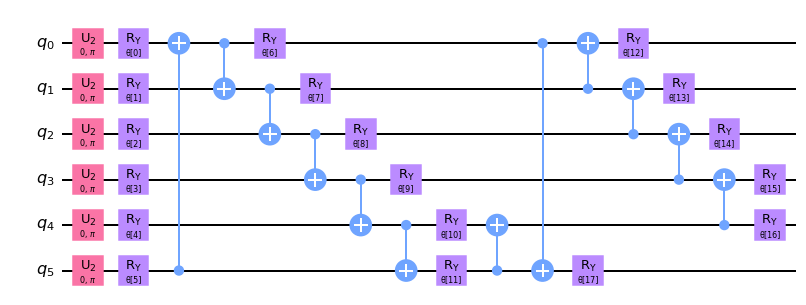

In [7]:
qc.decompose().draw("mpl")

### Initialization of a quantum generator
Next, we define a function that creates the quantum generator from a given parameterized quantum circuit. As parameters this function takes a quantum instance to be used for data sampling. We wrap a created quantum neural network in `TorchConnector` to make use of PyTorch-based training.

In [8]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import CircuitQNN


def create_generator(quantum_instance) -> TorchConnector:
    circuit_qnn = CircuitQNN(
        qc,
        input_params=[],
        weight_params=qc.parameters,
        quantum_instance=quantum_instance,
        sampling=True,
        sparse=False,
        input_gradients=True,  # TODO: !!!!!! Check out if they are required !!!!!!!
        interpret=lambda x: grid_elements[x],
    )

    return TorchConnector(circuit_qnn)

### Definition of classical discriminator
Next, we define a PyTorch-based classical neural network that represents the classical discriminator. The underlying gradients can be automatically computed with PyTorch.

In [9]:
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

### Definition of the loss functions
We want to train the generator and the discriminator with binary cross entropy as loss function:
$$L\left(\boldsymbol{\theta}\right)=\sum_jp_j\left(\boldsymbol{\theta}\right)\left[y_j\log(x_j) + (1-y_j)\log(1-x_j)\right],$$
where $x_j$ refers to a data sample and $y_j$ to the corresponding label.

In [10]:
# Generator loss function
gen_loss_fun = nn.BCELoss()

# Discriminator loss function
disc_loss_fun = nn.BCELoss()

### Evaluation of custom gradients for the generator BCE loss function
The evaluation of custom gradients for the quantum generator requires us to combine quantum gradients $\frac{\partial p_j\left(\boldsymbol{\theta}\right)}{\partial \theta_l}$ that we compute with Qiskit's gradient framework with the binary cross entropy as follows:
$$\frac{\partial L\left(\boldsymbol{\theta}\right)}{\partial \theta_l} = \sum_j \frac{\partial p_j\left(\boldsymbol{\theta}\right)}{\partial \theta_l} \left[y_j\log(x_j) + (1-y_j)\log(1-x_j)\right].$$

First, we need to define how gradients will be evaluated. Depending on the backend, the gradients may be returned in a sparse format. Since PyTorch provides only a limited support for sparse gradients, we need to write a custom function for gradient based training.

In [11]:
from qiskit.opflow import Gradient, StateFn

generator_grad = Gradient().gradient_wrapper(
    StateFn(qc), twolocal.ordered_parameters, backend=qi_training
)

Here, we define the custom function that evaluates gradients of the generator loss function considering the custom gradients of the quantum generator. As the parameters the function takes a list of parameter values and the discriminator as a classical neural network. The function returns a list of gradient values.

In [12]:
import torch.nn.functional as F


def generator_loss_grad(parameter_values, discriminator):
    # evaluate gradient
    grads = generator_grad(parameter_values).tolist()

    loss_grad = ()
    for j, grad in enumerate(grads):
        cx = grad[0].tocoo()
        input = torch.zeros(len(cx.col), len(data_dim))
        target = torch.ones(len(cx.col), 1)
        weight = torch.zeros(len(cx.col), 1)

        for i, (index, prob_grad) in enumerate(zip(cx.col, cx.data)):
            input[i, :] = grid_elements[index]
            weight[i, :] = prob_grad
        bce_loss_grad = F.binary_cross_entropy(discriminator(input), target, weight)
        loss_grad += (bce_loss_grad,)
    loss_grad = torch.stack(loss_grad)
    return loss_grad

### Relative entropy as benchmarking metric
The relative entropy describes a distance metric for distributions. Hence, we can use it to benchmark how close/far away the trained distribution is from the target distribution.

In the next function we computes relative entropy between target and trained distribution.

In [13]:
def get_relative_entropy(gen_data) -> float:
    prob_gen = np.zeros(len(grid_elements))
    for j, item in enumerate(grid_elements):
        for gen_item in gen_data.detach().numpy():
            if np.allclose(np.round(gen_item, 6), np.round(item, 6), rtol=1e-5):
                prob_gen[j] += 1
    prob_gen = prob_gen / len(gen_data)
    prob_gen = [1e-8 if x == 0 else x for x in prob_gen]
    return entropy(prob_gen, prob_data)

### Definition of the optimizers
In order to train the generator and discriminator, we need to define optimization schemes. In the following, we employ a momentum based optimizer called Adam, see [Kingma et al., Adam: A method for stochastic optimization](https://arxiv.org/abs/1412.6980) for more details.

In [14]:
from torch.optim import Adam

# Initialize generator and discriminator
generator = create_generator(qi_training)
discriminator = Discriminator(len(data_dim))

lr = 0.01  # learning rate
b1 = 0.9  # first momentum parameter
b2 = 0.999  # second momentum parameter
num_epochs = 10  # number of training epochs

# optimizer for the generator
optimizer_gen = Adam(generator.parameters(), lr=lr, betas=(b1, b2))
# optimizer for the discriminator
optimizer_disc = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

### Visualization of the training process
We will visualize what is happening during the training by plotting the evolution of the generator's and the discriminator's loss functions during the training, as well as the progress in the relative entropy between the trained and the target distribution. We define a function that plots the loss functions and relative entropy. We call this function once an epoch of training is complete.

Visualization of the training process begins when training data is collected across two epochs.

In [15]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(relative_entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

### Training
Now, we are ready to train our model. It may take some time to train the model so be patient.

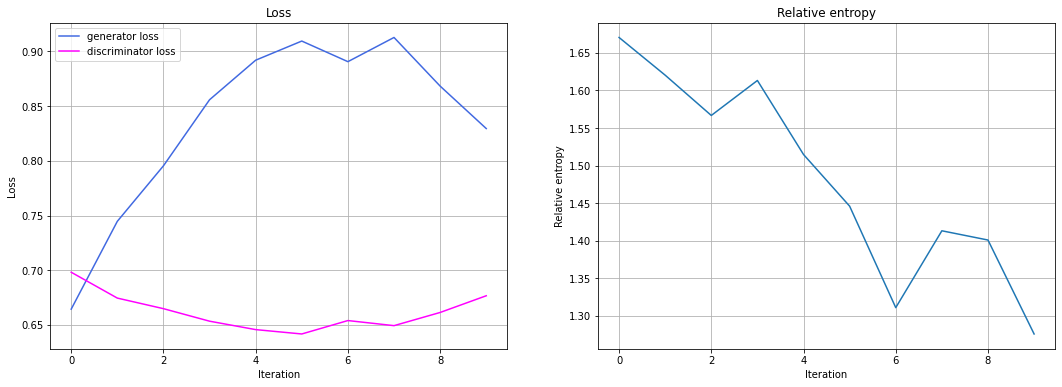

In [16]:
from scipy.stats import entropy

# Relative entropy list
relative_entropy_values = []
# Generator loss list
generator_loss_values = []
# Discriminator loss list
discriminator_loss_values = []

for epoch in range(num_epochs):
    relative_entropy_epoch = []
    generator_loss_epoch = []
    discriminator_loss_epoch = []
    for i, data in enumerate(dataloader):
        # Adversarial ground truths
        valid = torch.ones(data.size(0), 1)
        fake = torch.zeros(data.size(0), 1)

        # Generate a batch of data points
        gen_data = generator()

        # Evaluate Relative Entropy
        relative_entropy_epoch.append(get_relative_entropy(gen_data))

        # Train Discriminator
        optimizer_disc.zero_grad()

        # Loss measures discriminator's ability to distinguish real from generated samples
        disc_data = discriminator(data)

        real_loss = disc_loss_fun(disc_data, valid)
        fake_loss = disc_loss_fun(discriminator(gen_data), fake)
        discriminator_loss = (real_loss + fake_loss) / 2

        discriminator_loss.backward(retain_graph=True)
        optimizer_disc.step()

        # Train Generator
        optimizer_gen.zero_grad()

        # Loss measures generator's ability to prepare good data samples
        generator_loss = gen_loss_fun(discriminator(gen_data), valid)
        generator_loss.retain_grad = True
        g_loss_grad = generator_loss_grad(generator.weight.data.numpy(), discriminator)

        # generator_loss.backward(retain_graph=True)
        for j, param in enumerate(generator.parameters()):
            param.grad = g_loss_grad
        optimizer_gen.step()

        generator_loss_epoch.append(generator_loss.item())
        discriminator_loss_epoch.append(discriminator_loss.item())

    relative_entropy_values.append(np.mean(relative_entropy_epoch))
    generator_loss_values.append(np.mean(generator_loss_epoch))
    discriminator_loss_values.append(np.mean(discriminator_loss_epoch))

    plot_training_progress()

### Results: cumulative distribution functions
In the final section we compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

We create a new generator for sampling that takes more shots and, hence, gives more information. Recall, the sampling quantum instance was created with a larger number of shots. Then, we set the weights of the sampling generator to the values obtained in the training process.

In [17]:
generator_sampling = create_generator(qi_sampling)
generator_sampling.weight.data = generator.weight.data

Next, we wet the generator data samples, corresponding sampling probabilities, and plot the cumulative distribution functions.

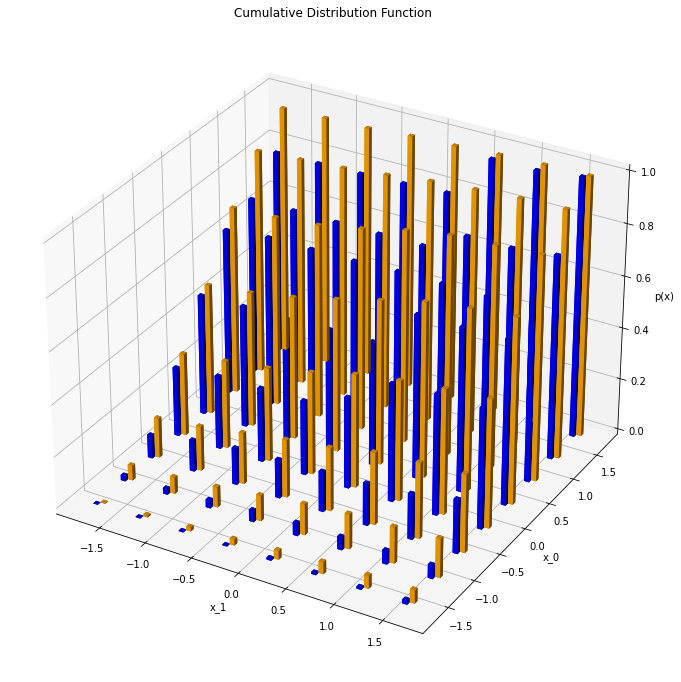

In [18]:
gen_data = generator_sampling().detach().numpy()
prob_gen = np.zeros(len(grid_elements))
for j, item in enumerate(grid_elements):
    for gen_item in gen_data:
        if np.allclose(np.round(gen_item, 6), np.round(item, 6), rtol=1e-5):
            prob_gen[j] += 1
prob_gen = prob_gen / len(gen_data)

prob_gen = [1e-8 if x == 0 else x for x in prob_gen]
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(111, projection="3d")
ax1.set_title("Cumulative Distribution Function")
# there's a known issue in matplotlit with placing a legend on the 3d plot
ax1.bar3d(
    np.transpose(grid_elements)[1],
    np.transpose(grid_elements)[0],
    np.zeros(len(prob_gen)),
    0.05,
    0.05,
    np.cumsum(prob_gen),
    label="generated data",
    color="blue",
    alpha=1,
)
ax1.bar3d(
    np.transpose(grid_elements)[1] + 0.05,
    np.transpose(grid_elements)[0] + 0.05,
    np.zeros(len(prob_data)),
    0.05,
    0.05,
    np.cumsum(prob_data),
    label="training data",
    color="orange",
    alpha=1,
)
# ax1.legend(loc='upper right')
ax1.set_xlabel("x_1")
ax1.set_ylabel("x_0")
ax1.set_zlabel("p(x)")
plt.show()

On the plot above, in the <span style="color:blue">blue color</span> the generated distribution is shown and 
in the <span style="color:orange">orange color</span> the training one. You may find that both CDFs are similar to each other.|

In [19]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright